# Benchmark Analysis - H5

In [55]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [56]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple

%matplotlib inline

In [57]:
matplotlib.style.use('seaborn-v0_8')  

In [58]:
device_name = 'hydrac'
core_list = [1,2,4,8,16,32]

In [59]:
root_dir = '/Users/diego/Desktop/BENCHMARK_HYDRA_CPU_67M_WITH_BYTES'

In [60]:
GCC_TBB_COLOR = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'

NVC_OMP_COLOR = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'

NVC_GPU_COLOR = 'beige'


In [61]:
plot_save_dir = './plots/h5'

## Utils 

In [62]:
def get_path(*entries):
    return os.path.join(*entries)

In [63]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [64]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"),bbox_inches='tight')
    plt.show()

In [65]:
def extraction_pandas_frame_algo(path, COMP="TODO",include_bytes_per_second=False):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                    axis=1)

    if not include_bytes_per_second:
        df = df.drop(columns=['bytes_per_second'])

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev','max','min'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 5 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 5 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    # set max bytes per second
    results_gcc['max_id'] = results_gcc['C'] * 5 + 3
    
    # max bytes per seconds as bytes per second
    if include_bytes_per_second:
        results_gcc['bytes_per_second'] = results_gcc['max_id'].apply(lambda x: df.iloc[x]['bytes_per_second'])

    # min time as real_time
    results_gcc['min_id'] = results_gcc['C'] * 5 + 4
    results_gcc['real_time'] = results_gcc['min_id'].apply(lambda x: df.iloc[x]['real_time'])


    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id','min_id','max_id'], axis=1)
    results_gcc['Compiler'] = 'COMP'
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [66]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [67]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [68]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [69]:
def par_data_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    # load bench_name
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{bench_name}_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df

In [70]:

def get_seq_base(benchmark_name:str) -> pd.DataFrame:

    time_filed_name = 'real_time'

    compiler_instances = [
        ('GCC_TBB','GCC(TBB)'),
        ('NVHPC_Multicore','NVC(OMP)')
    ]

    start_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[0][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
    min_val = start_df[time_filed_name].min()
    min_df = start_df


    for i in range(1,len(compiler_instances)):
        current_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[i][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
        current_min = current_df[time_filed_name].min()

        if current_min < min_val:
            min_val = current_min
            min_df = current_df

    return min_df

In [71]:
def get_strong_scaling_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = get_seq_base(bench_name)
    
    ## threaded
    df = extraction_pandas_frame_algo_threaded(f'{root_dir}/{compiler_location}/THREADS',
                                               f'{bench_name}_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")

# H5
> Parallel stl backends use special parallelism techniques for linear algorithms, which have no clear reference
> implementation, leading to significant differences in terms of performance and their strong scaling properties.


## `b5_1_find_std::vector<int>_first_entry_par`

In [72]:
benchmark_name = "b5_1_find_std::vector<int>_first_entry"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_1_find_std::vector<int>_first_entry_par`

Check how the runtime without constraining the threads develops with increasing input size

In [73]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_1_find_std_vector_int_first_entry_time_merged = pd.merge(*data, on='n')

b5_1_find_std_vector_int_first_entry_time_merged

,GCC(TBB),n,NVC(OMP)
0,2402.52,4,19249.0
1,5002.08,8,21855.9
2,9164.18,16,22905.5
3,12841.90,32,22814.5
4,17817.10,64,22896.8
5,22494.40,128,22759.4
6,24817.50,256,22841.4
7,28056.70,512,22644.6
8,31701.10,1024,22648.4
9,34015.90,2048,22712.2


### Strong Scaling - `b5_1_find_std::vector<int>_first_entry`
 
2^26 fixed input size with threads 1-64

In [74]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_1_find_std_vector_int_first_entry_strong_scaling_merged = pd.merge(*data, on='threads')

b5_1_find_std_vector_int_first_entry_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.000429,0.000019
1,2,0.000801,0.000038
2,4,0.001075,0.000073
3,8,0.001269,0.000134
4,16,0.001373,0.000231
5,32,0.001017,0.000362


In [75]:
## efficiency graph

b5_1_find_std_vector_int_first_entry_efficiency = b5_1_find_std_vector_int_first_entry_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b5_1_find_std_vector_int_first_entry_efficiency[f'{compiler_name}'] = b5_1_find_std_vector_int_first_entry_efficiency[f'{compiler_name}'] / b5_1_find_std_vector_int_first_entry_efficiency['threads']



b5_1_find_std_vector_int_first_entry_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.000429,0.000019
1,2,0.000401,0.000019
2,4,0.000269,0.000018
3,8,0.000159,0.000017
4,16,0.000086,0.000014
5,32,0.000032,0.000011


### Plots

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_16027/3160213828.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


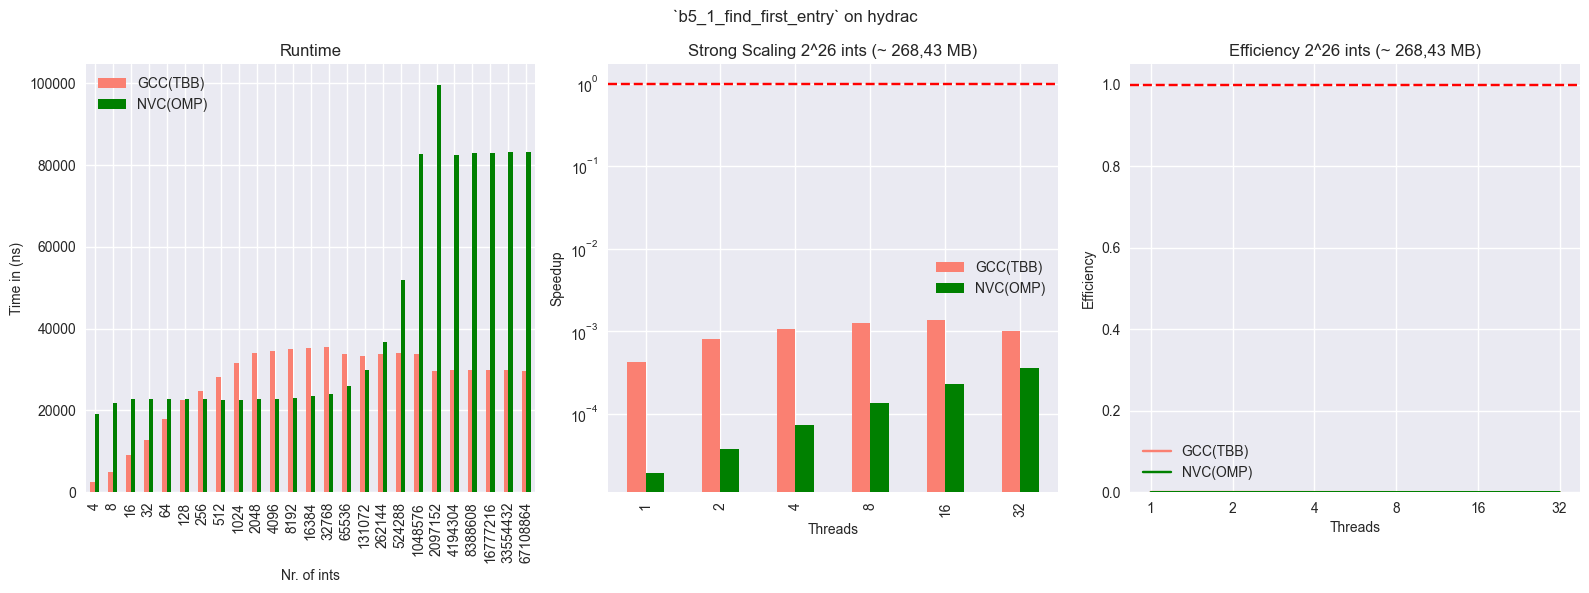

In [76]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_1_find_std_vector_int_first_entry_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')



# plot strong scaling
ax_2 = b5_1_find_std_vector_int_first_entry_strong_scaling_merged.plot(kind='bar',
                                                        x='threads',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1]
                                                    )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_yscale('log',base=10)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')




# plot efficiency
ax_3 = b5_1_find_std_vector_int_first_entry_efficiency.plot(x='threads',
                                             color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                             ax=axes[2]
                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b5_1_find_first_entry` on {device_name}")

fig.tight_layout()

plot(f"`b5_1_find_first_entry` {device_name}")

## `b5_1_find_std::vector<int>_last_entry_par`

In [77]:
benchmark_name = "b5_1_find_std::vector<int>_last_entry"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_1_find_std::vector<int>_last_entry_par`

Check how the runtime without constraining the threads develops with increasing input size

In [78]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_1_find_std_vector_int_last_entry_time_merged = pd.merge(*data, on='n')

b5_1_find_std_vector_int_last_entry_time_merged

,GCC(TBB),n,NVC(OMP)
0,2407.45,4,20193.9
1,4919.15,8,19972.3
2,9009.44,16,23126.9
3,13740.00,32,23446.1
4,16660.40,64,22678.5
5,21019.30,128,22734.3
6,24575.90,256,22715.0
7,26945.40,512,22745.2
8,29582.70,1024,22994.5
9,33529.00,2048,23360.6


### Strong Scaling - `b5_1_find_std::vector<int>_last_entry`
 
2^26 fixed input size with threads 1-64

In [79]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_1_find_std_vector_int_last_entry_strong_scaling_merged = pd.merge(*data, on='threads')

b5_1_find_std_vector_int_last_entry_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.858894,0.234349
1,2,1.663950,0.464355
2,4,3.208053,0.917796
3,8,6.366019,1.782905
4,16,10.838961,3.299927
5,32,14.779048,5.746144


In [80]:
## efficiency graph

b5_1_find_std_vector_int_last_entry_efficiency = b5_1_find_std_vector_int_last_entry_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_1_find_std_vector_int_last_entry_efficiency[f'{compiler_name}'] = b5_1_find_std_vector_int_last_entry_efficiency[f'{compiler_name}'] / b5_1_find_std_vector_int_last_entry_efficiency['threads']



b5_1_find_std_vector_int_last_entry_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.858894,0.234349
1,2,0.831975,0.232178
2,4,0.802013,0.229449
3,8,0.795752,0.222863
4,16,0.677435,0.206245
5,32,0.461845,0.179567


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_16027/2173686038.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


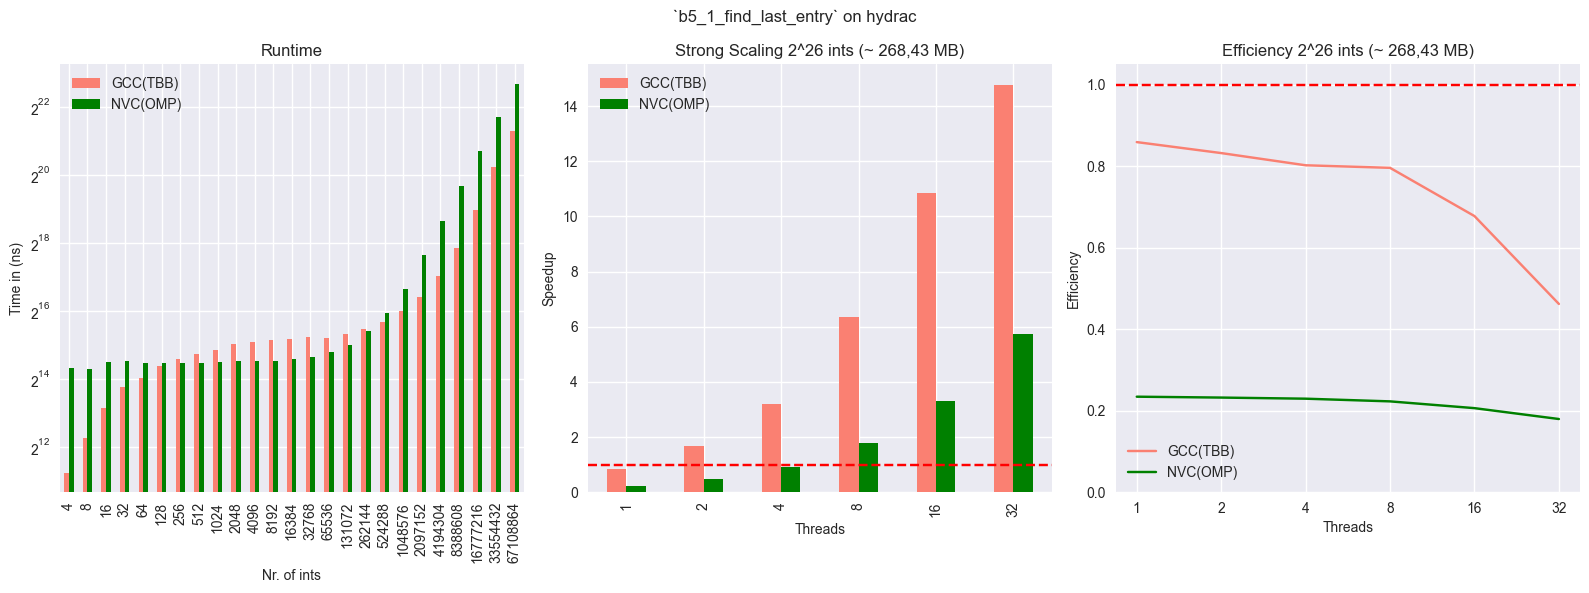

In [81]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_1_find_std_vector_int_last_entry_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_1_find_std_vector_int_last_entry_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,5)

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_1_find_std_vector_int_last_entry_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')



fig.suptitle(f"`b5_1_find_last_entry` on {device_name}")

fig.tight_layout()

plot(f"`b5_1_find_last_entry` {device_name}")

## `b5_1_find_std::vector<int>_non_existing_entry_par`

In [82]:
benchmark_name = "b5_1_find_std::vector<int>_non_existing_entry"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_1_find_std::vector<int>_non_existing_entry_par`

Check how the runtime without constraining the threads develops with increasing input size

In [83]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_1_find_std_vector_int_non_existing_entry_time_merged = pd.merge(*data, on='n')

b5_1_find_std_vector_int_non_existing_entry_time_merged

,GCC(TBB),n,NVC(OMP)
0,2371.81,4,19827.6
1,4925.05,8,20141.7
2,8492.66,16,22525.8
3,12880.50,32,22990.6
4,17259.30,64,23079.0
5,21578.00,128,23724.9
6,24891.10,256,23984.5
7,27637.30,512,24395.2
8,31387.00,1024,24221.3
9,35948.20,2048,23944.1


### Strong Scaling - `b5_1_find_std::vector<int>_non_existing_entry`
 
2^26 fixed input size with threads 1-64

In [84]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_1_find_std_vector_int_non_existing_entry_strong_scaling_merged = pd.merge(*data, on='threads')

b5_1_find_std_vector_int_non_existing_entry_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.101906,0.345653
1,2,2.033453,0.676592
2,4,3.904058,1.317641
3,8,7.199839,2.594975
4,16,10.993658,4.532418
5,32,13.270217,6.533087


In [85]:
## efficiency graph

b5_1_find_std_vector_int_non_existing_entry_efficiency = b5_1_find_std_vector_int_non_existing_entry_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_1_find_std_vector_int_non_existing_entry_efficiency[f'{compiler_name}'] = b5_1_find_std_vector_int_non_existing_entry_efficiency[f'{compiler_name}'] / b5_1_find_std_vector_int_non_existing_entry_efficiency['threads']



b5_1_find_std_vector_int_non_existing_entry_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.101906,0.345653
1,2,1.016726,0.338296
2,4,0.976015,0.329410
3,8,0.899980,0.324372
4,16,0.687104,0.283276
5,32,0.414694,0.204159


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_16027/2018566896.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


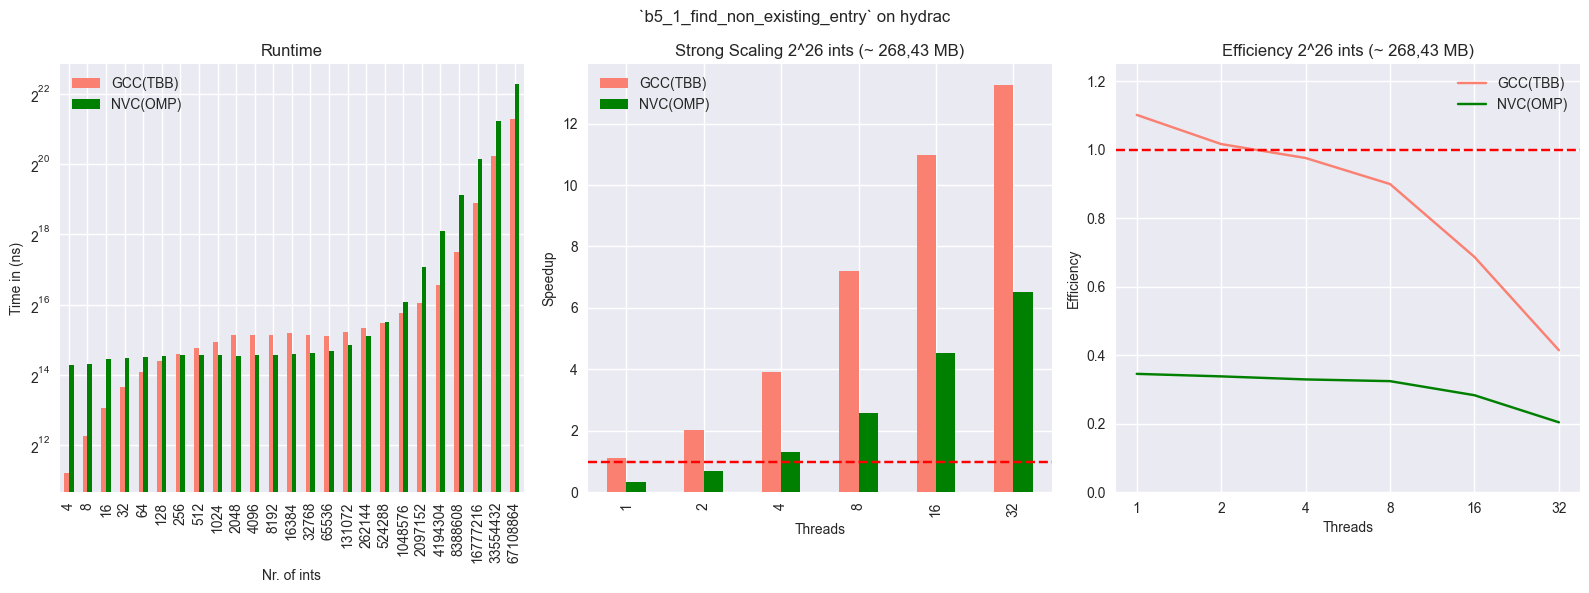

In [86]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_1_find_std_vector_int_non_existing_entry_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_1_find_std_vector_int_non_existing_entry_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_1_find_std_vector_int_non_existing_entry_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')



fig.suptitle(f"`b5_1_find_non_existing_entry` on {device_name}")

fig.tight_layout()

plot(f"`b5_1_find_non_existing_entry` {device_name}")

## `b5_2_partition_par`

In [87]:
benchmark_name = "b5_2_partition"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_2_partition_par`

Check how the runtime without constraining the threads develops with increasing input size

In [88]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_2_partition_time_merged = pd.merge(*data, on='n')

b5_2_partition_time_merged

,GCC(TBB),n,NVC(OMP)
0,3006.65,4,1.307070e+02
1,6170.77,8,2.062140e+02
2,10831.40,16,3.536860e+02
3,15279.30,32,6.559840e+02
4,19613.40,64,1.254320e+03
5,24806.40,128,2.457290e+03
6,28916.90,256,4.849380e+03
7,34230.10,512,9.611740e+03
8,41532.30,1024,1.917350e+04
9,52581.00,2048,3.831110e+04


### Strong Scaling - `b5_2_partition_strong_par`
 
2^26 fixed input size with threads 1-64

In [89]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_2_partition_strong_scaling_merged = pd.merge(*data, on='threads')

b5_2_partition_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.779229,0.980098
1,2,1.443859,0.980526
2,4,2.775040,0.924088
3,8,5.418554,0.945990
4,16,10.719347,0.979853
5,32,21.204174,0.978184


In [90]:
## efficiency graph

b5_2_partition_efficiency = b5_2_partition_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_2_partition_efficiency[f'{compiler_name}'] = b5_2_partition_efficiency[f'{compiler_name}'] / b5_2_partition_efficiency['threads']



b5_2_partition_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.779229,0.980098
1,2,0.721929,0.490263
2,4,0.693760,0.231022
3,8,0.677319,0.118249
4,16,0.669959,0.061241
5,32,0.662630,0.030568


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_16027/1463862148.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


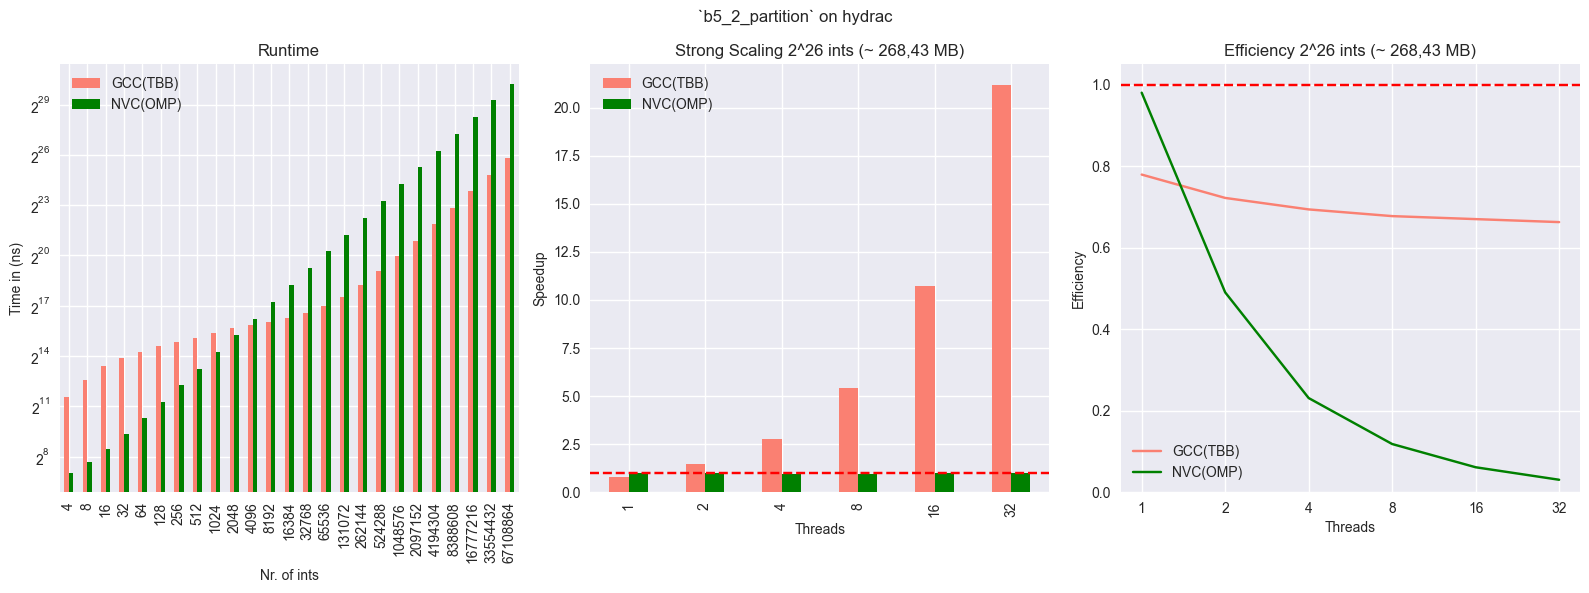

In [91]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_2_partition_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_2_partition_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_2_partition_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b5_2_partition` on {device_name}")

fig.tight_layout()

plot(f"`b5_2_partition` {device_name}")

## `b5_3_unique_copy_default_par`

In [92]:
benchmark_name = "b5_3_unique_copy_default"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_3_unique_copy_default_par`

Check how the runtime without constraining the threads develops with increasing input size

In [93]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_3_unique_copy_default_time_merged = pd.merge(*data, on='n')

b5_3_unique_copy_default_time_merged

,GCC(TBB),n,NVC(OMP)
0,8327.13,4,10685.8
1,17801.20,8,10951.3
2,30122.90,16,11744.1
3,40067.40,32,12614.1
4,54726.50,64,12381.5
5,76493.90,128,12769.8
6,76915.60,256,12935.8
7,74856.60,512,13872.3
8,80198.10,1024,13840.6
9,80892.70,2048,15559.3


### Strong Scaling - `b5_3_unique_copy_default_strong_par`
 
2^26 fixed input size with threads 1-64

In [94]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_3_unique_copy_default_strong_scaling_merged = pd.merge(*data, on='threads')

b5_3_unique_copy_default_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.282891,0.095291
1,2,0.558123,0.147478
2,4,1.079988,0.193002
3,8,1.879125,0.242943
4,16,2.919315,0.269754
5,32,4.000708,0.276837


In [95]:
## efficiency graph

b5_3_unique_copy_default_efficiency = b5_3_unique_copy_default_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_3_unique_copy_default_efficiency[f'{compiler_name}'] = b5_3_unique_copy_default_efficiency[f'{compiler_name}'] / b5_3_unique_copy_default_efficiency['threads']



b5_3_unique_copy_default_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.282891,0.095291
1,2,0.279062,0.073739
2,4,0.269997,0.048251
3,8,0.234891,0.030368
4,16,0.182457,0.016860
5,32,0.125022,0.008651


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_16027/1087304379.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


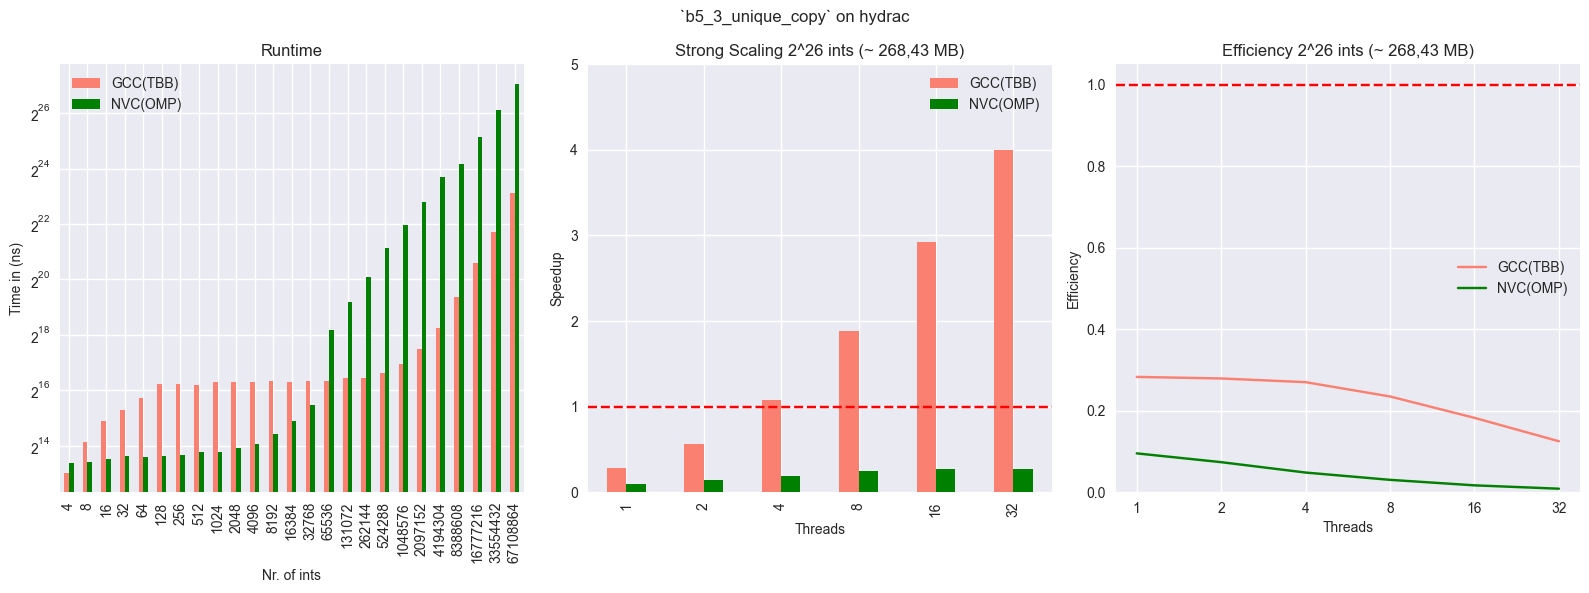

In [96]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_3_unique_copy_default_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_3_unique_copy_default_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,5)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_3_unique_copy_default_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b5_3_unique_copy` on {device_name}")

fig.tight_layout()

plot(f"`b5_3_unique_copy` {device_name}")

## `b5_4_minmax_element_all_equal_par`

In [97]:
benchmark_name = "b5_4_minmax_element_all_equal"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_4_minmax_element_all_equal_par`

Check how the runtime without constraining the threads develops with increasing input size

In [98]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_4_minmax_element_all_equal_time_merged = pd.merge(*data, on='n')

b5_4_minmax_element_all_equal_time_merged

,GCC(TBB),n,NVC(OMP)
0,1805.10,4,19991.0
1,4482.58,8,21027.7
2,8973.28,16,22446.1
3,13859.50,32,22890.7
4,18010.40,64,22479.2
5,23742.40,128,22461.8
6,26894.30,256,22691.0
7,30135.50,512,23209.6
8,34007.20,1024,23291.2
9,39167.30,2048,23423.6


### Strong Scaling - `b5_4_minmax_element_all_equal_strong_par`
 
2^26 fixed input size with threads 1-64

In [99]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_4_minmax_element_all_equal_strong_scaling_merged = pd.merge(*data, on='threads')

b5_4_minmax_element_all_equal_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,2.026368,0.207936
1,2,4.302539,0.415646
2,4,8.283036,0.830647
3,8,15.950378,1.659458
4,16,29.618872,3.315056
5,32,43.910779,6.602385


In [100]:
## efficiency graph

b5_4_minmax_element_all_equal_efficiency = b5_4_minmax_element_all_equal_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_4_minmax_element_all_equal_efficiency[f'{compiler_name}'] = b5_4_minmax_element_all_equal_efficiency[f'{compiler_name}'] / b5_4_minmax_element_all_equal_efficiency['threads']



b5_4_minmax_element_all_equal_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,2.026368,0.207936
1,2,2.151270,0.207823
2,4,2.070759,0.207662
3,8,1.993797,0.207432
4,16,1.851180,0.207191
5,32,1.372212,0.206325


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_16027/535999449.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


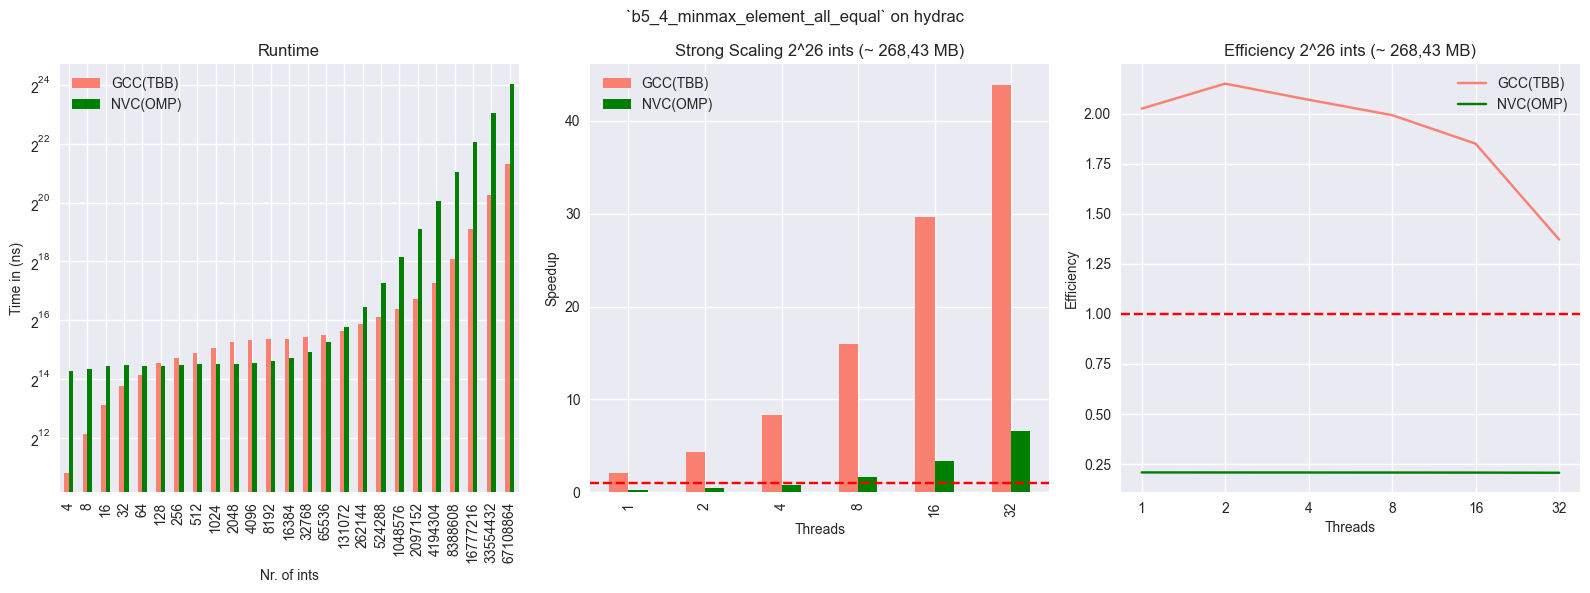

In [101]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_4_minmax_element_all_equal_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_4_minmax_element_all_equal_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')


#ax_2.set_ylim(0,16)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_4_minmax_element_all_equal_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b5_4_minmax_element_all_equal` on {device_name}")

fig.tight_layout()

plot(f"`b5_4_minmax_element_all_equal` {device_name}")

## `b5_4_minmax_element_increasing_par`

In [102]:
benchmark_name = "b5_4_minmax_element_increasing"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_4_minmax_element_increasing_par`

Check how the runtime without constraining the threads develops with increasing input size

In [103]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_4_minmax_element_increasing_time_merged = pd.merge(*data, on='n')

b5_4_minmax_element_increasing_time_merged

,GCC(TBB),n,NVC(OMP)
0,1903.39,4,19603.6
1,4562.94,8,19787.6
2,9157.63,16,21462.8
3,13559.10,32,22146.3
4,17828.90,64,23421.3
5,23422.50,128,24228.8
6,27229.50,256,24297.0
7,31428.90,512,24131.3
8,35915.20,1024,24905.2
9,41139.10,2048,25097.7


### Strong Scaling - `b5_4_minmax_element_increasing_strong_par`
 
2^26 fixed input size with threads 1-64

In [104]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_4_minmax_element_increasing_strong_scaling_merged = pd.merge(*data, on='threads')

b5_4_minmax_element_increasing_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,2.163386,0.235468
1,2,4.274908,0.470585
2,4,8.341452,0.940867
3,8,16.273785,1.880565
4,16,29.922379,3.755710
5,32,43.680141,7.477657


In [105]:
## efficiency graph

b5_4_minmax_element_increasing_efficiency = b5_4_minmax_element_increasing_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_4_minmax_element_increasing_efficiency[f'{compiler_name}'] = b5_4_minmax_element_increasing_efficiency[f'{compiler_name}'] / b5_4_minmax_element_increasing_efficiency['threads']



b5_4_minmax_element_increasing_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,2.163386,0.235468
1,2,2.137454,0.235293
2,4,2.085363,0.235217
3,8,2.034223,0.235071
4,16,1.870149,0.234732
5,32,1.365004,0.233677


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_16027/1646294840.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


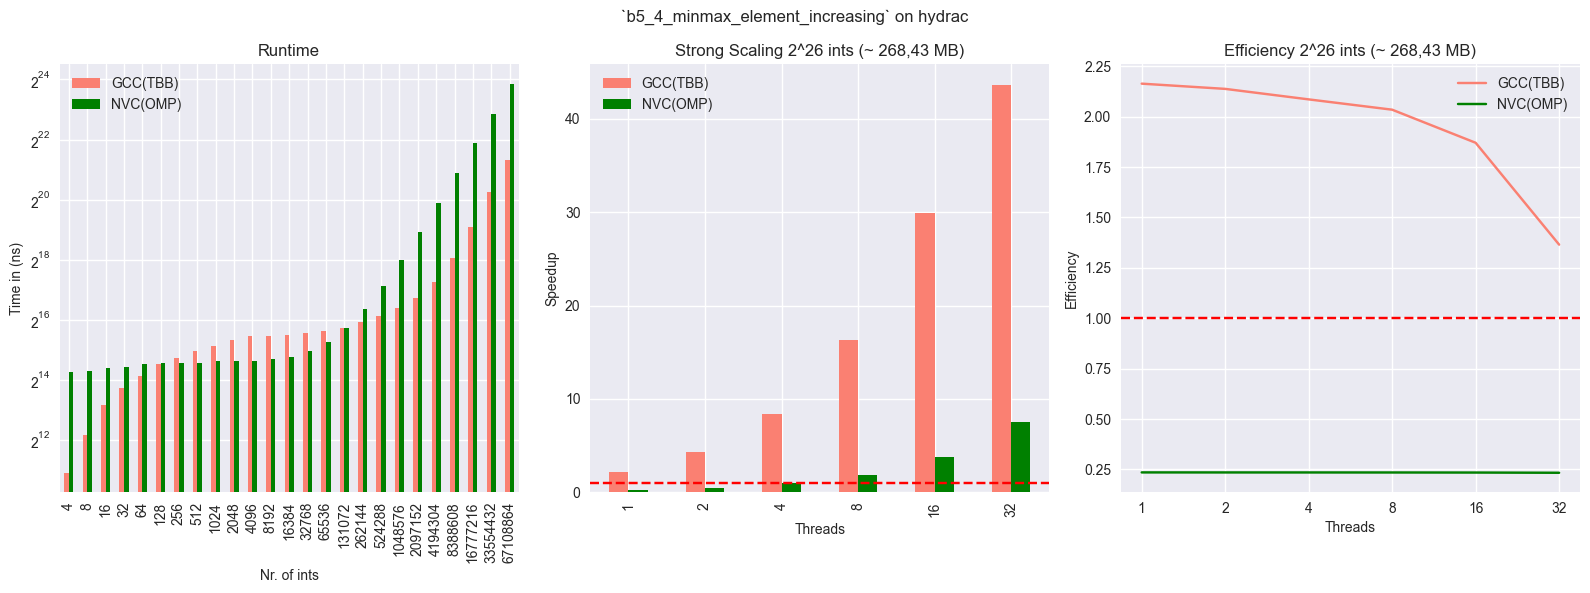

In [106]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_4_minmax_element_increasing_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_4_minmax_element_increasing_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,14)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_4_minmax_element_increasing_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b5_4_minmax_element_increasing` on {device_name}")

fig.tight_layout()

plot(f"`b5_4_minmax_element_increasing` {device_name}")

######################## DIVIDER ########################

## Performance Portability Calculation (Inter Compiler)

Runtime 

In [107]:
# calc pp_metrics

def calc_pp(data_points:List[int]) -> int:
    min_val = min(data_points)
    return len(data_points) / sum([1/(min_val/val) for val in data_points])

compilers = ['GCC(TBB)','NVC(OMP)']

pp_df = pd.DataFrame(columns=['name','GCC(TBB)','NVC(OMP)','PP'])


data_fields = [
    ('b5_1_find_first_entry',b5_1_find_std_vector_int_first_entry_time_merged),
    ('b5_1_find_last_entry',b5_1_find_std_vector_int_last_entry_time_merged),
    ('b5_1_find_non_existing',b5_1_find_std_vector_int_non_existing_entry_time_merged),

    ('b5_2_partition',b5_2_partition_time_merged),

    ('b5_3_unique_copy',b5_3_unique_copy_default_time_merged),

    ('b5_4_minmax_element_all_equal',b5_4_minmax_element_all_equal_time_merged),
    ('b5_4_minmax_element_increasing',b5_4_minmax_element_increasing_time_merged),
    
]

for data in data_fields:

    entry_dict = {
        'name': [data[0]],
    }

    vals = []

    for comp in compilers:
        current_val = int(data[1].iloc[-1][comp])
        entry_dict[comp] = [current_val]

        vals.append(current_val)

    entry_dict['PP'] = calc_pp(vals)

    other_df = pd.DataFrame.from_dict(entry_dict)
    pp_df = pd.concat([pp_df,other_df],ignore_index=True)


pp_df['INTERPRET'] = np.where(pp_df['PP']>0.85, 'GOOD', 'BAD')

pp_df



,name,GCC(TBB),NVC(OMP),PP,INTERPRET
0,b5_1_find_first_entry,29626,83119,0.525540,BAD
1,b5_1_find_last_entry,2560170,6694060,0.553297,BAD
2,b5_1_find_non_existing,2551330,5115520,0.665548,BAD
3,b5_2_partition,59317500,1276520000,0.088809,BAD
4,b5_3_unique_copy,9226050,140726000,0.123053,BAD
5,b5_4_minmax_element_all_equal,2621710,17264200,0.263675,BAD
6,b5_4_minmax_element_increasing,2599910,15239100,0.291486,BAD


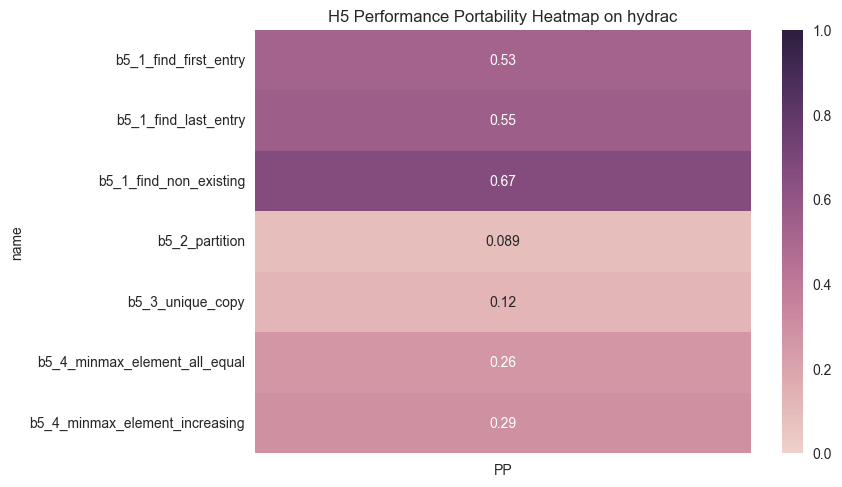

In [108]:
import seaborn as sns

heatmap_pp_df = pp_df.copy()
heatmap_pp_df = heatmap_pp_df.drop(columns=['GCC(TBB)','NVC(OMP)','INTERPRET'])
heatmap_pp_df = heatmap_pp_df.set_index(['name'])


sns.heatmap(heatmap_pp_df, annot=True,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1)

plt.title(f'H5 Performance Portability Heatmap on {device_name}')

plot(f'H5 Performance Portability Heatmap on {device_name}')

## Findings for H5

### XXX

### General


### GPU Findings


### Hypothesis Findings


